
---

## 🧭 Problem Setting

### **Custom GridWorld Environment**

In this assignment, we work with a **custom-built GridWorld environment** designed to simulate a simple Markov Decision Process (MDP). The environment is a 2D grid where an agent navigates from a starting position toward one or more goal states, while avoiding obstacles and boundaries.

The agent can take **five actions**:

* `"up"`
* `"down"`
* `"left"`
* `"right"`
* `"stay"` (remain in place)

Each move transitions the agent to a new state (unless blocked by a boundary), and the environment provides a reward based on the resulting state.

---

### **Grid Structure and Dynamics**

* The grid has configurable **rows** and **columns**, and is initialized with:

  * **Goal cells**: Deliver **positive reward** (e.g. `+100`) and are treated as terminal in theory (though episodes do not stop automatically in this implementation).
  * **Obstacle cells**: Deliver **negative reward** (e.g. `-40`) and encourage the agent to find safer paths.
  * **Boundary cells**: Represent the outer edge of the grid (e.g. `-100` reward). These are impassable and penalizing.
  * **Neutral cells**: Regular empty tiles that return `0` reward.

* The agent begins each episode at a designated starting location (e.g. `(0, 0)`), or a random location within the valid grid interior if `random_init=True`.

* Each episode runs for a fixed number of steps (`episode_steps`), regardless of whether a goal is reached — there is **no explicit termination** on success or failure.

---

### **Rewards**

* **Goal state** → High positive reward (e.g. `+100`)
* **Obstacle state** → Moderate penalty (e.g. `-40`)
* **Boundary state** → Strong penalty (e.g. `-100`)
* **Other states** → Neutral (reward `0`)

The agent learns to **maximize cumulative reward** by identifying efficient, safe paths to the goal while avoiding traps and boundaries.

---


In [ ]:
from typing import Tuple
%pip install celluloid
from celluloid import Camera # getting the camera
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import TwoSlopeNorm, Normalize
import numpy as np
import random


### Visualization Tools ###

### Visualization Tools ###

class Move_anim:
    """
    This class provides functionality for visualizing the motion of a trained
    agent in real-time using matplotlib and a camera-like snapshot tool.

    Args:
        ax_obj (matplotlib axis): The axis to draw the animation on.
        cam_obj (camera object): The camera used to capture frames (e.g., celluloid).
        obs (list or np.ndarray): List of obstacle coordinates.
        goal (list or np.ndarray): Goal coordinate.
        bounds (list): Boundary coordinates.
        grid_size (float): Size of each grid cell in the animation.
        T (float): Time to animate a single move.
        invert (bool): Whether to swap row/col in coordinate conversion.
    """

    def __init__(self, ax_obj, cam_obj, obs, goal, bounds, grid_size=1, T=1, invert=False):
        self.move_time = T
        self.grid_size = grid_size
        self.ax = ax_obj
        self.camera = cam_obj
        self.invert = invert
        self._legend_drawn = False

        # Ensure obs and goal are numpy arrays
        self.obs = np.array(obs) if not isinstance(obs, np.ndarray) else obs
        self.goal = np.array(goal) if not isinstance(goal, np.ndarray) else goal
        self.bounds = bounds


    def right(self, x, y):
        "Animate a rightward move"
        for i in range(int(self.move_time * 10)):
            x += self.grid_size / (10 * self.move_time)
            self.ax.scatter(x, y, c='black', edgecolors='white', s=120, marker='o')
            self.show_obs()
            self.camera.snap()
        return x, y


    def left(self, x, y):
        "Animate a leftward move"
        for i in range(int(self.move_time * 10)):
            x -= self.grid_size / (10 * self.move_time)
            self.ax.scatter(x, y, c='black', edgecolors='white', s=120, marker='o')
            self.show_obs()
            self.camera.snap()
        return x, y


    def up(self, x, y):
        "Animate an upward move"
        for i in range(int(self.move_time * 10)):
            y -= self.grid_size / (10 * self.move_time)
            self.ax.scatter(x, y, c='black', edgecolors='white', s=120, marker='o')
            self.show_obs()
            self.camera.snap()
        return x, y


    def down(self, x, y):
        "Animate a downward move"
        for i in range(int(self.move_time * 10)):
            y += self.grid_size / (10 * self.move_time)
            self.ax.scatter(x, y, c='black', edgecolors='white', s=120, marker='o')
            self.show_obs()
            self.camera.snap()
        return x, y


    def show_obs(self):
        "Show all static objects: obstacles, boundaries, and goal"
        def adapt_coords(pos):
            row, col = pos
            return (col + 0.5, row + 0.5) if self.invert else (row + 0.5, col + 0.5)

        # Draw obstacles (red x)
        for pos in self.obs:
            x, y = adapt_coords(pos)
            self.ax.scatter(x, y, c='red', marker='x', s=100)

        # Draw boundaries (black x)
        for pos in self.bounds:
            x, y = adapt_coords(pos)
            self.ax.scatter(x, y, c='black', marker='x', s=100)

        # Draw goal (green star)
        gx, gy = adapt_coords(self.goal)
        self.ax.scatter(gx, gy, c='green', marker='*', s=200)

        # Draw legend once
        if not self._legend_drawn:
            self.ax.scatter([], [], c='red', marker='x', s=100, label='Obstacle')
            self.ax.scatter([], [], c='black', marker='x', s=100, label='Boundary')
            self.ax.scatter([], [], c='green', marker='*', s=200, label='Goal')
            self.ax.scatter([], [], c='black', edgecolors='white', s=120, marker='o', label='Agent')
            self._legend_drawn = True

    # Execute and animate a full trajectory from (cur_x, cur_y)
    def execute_traj(self, traj, cur_x, cur_y):
        # Optionally swap row and col based on display preference
        if self.invert:
            cur_x, cur_y = cur_y, cur_x

        # Offset to center agent in the middle of a grid cell
        x = cur_x + 0.5
        y = cur_y + 0.5

        # Move the agent step-by-step based on the trajectory list
        for move in traj:
            if move == "right":
                x, y = self.right(x, y)
            elif move == "left":
                x, y = self.left(x, y)
            elif move == "up":
                x, y = self.up(x, y)
            elif move == "down":
                x, y = self.down(x, y)
            else:
                # No move (could handle invalid move here)
                x, y = x, y

        # Show legend after the full trajectory is played
        self.ax.legend(loc='upper right', fontsize=10)



### Method for visualizing q-table with directions corresponding to optimal actions for each state ###

def draw_q_grid(q_table, env, scale=1.5, actions=["stay", "up", "down", "left", "right"], focus_center=None, focus_size=3):
    """
    Visualizes the Q-values of a grid-based environment using directional arrows and color-coded heatmaps.

    Args:
        q_table (dict): A dictionary with keys as (state, action) pairs and values as Q-values.
        env (GridWorld): The grid environment (used for size and boundary info).
        scale (float): Controls the visual scaling of the plot.
        actions (list): List of action names corresponding to Q-values.
        focus_center (tuple): Optional (x, y) center to zoom into a subsection of the grid.
        focus_size (int): Size of the subsection to show if using focus_center.
    """

    # === Determine region to visualize ===
    if focus_center:
        cx, cy = focus_center
        half = focus_size // 2
        row_range = range(max(0, cy - half), min(env.rows, cy + half + 1))
        col_range = range(max(0, cx - half), min(env.cols, cx + half + 1))
    else:
        row_range = range(env.rows)
        col_range = range(env.cols)

    # Arrow offsets for directional visualization
    dx, dy = 0.25, 0.25
    arrow_dict = {"U": (0, -dy), "D": (0, dy), "L": (-dx, 0), "R": (dx, 0)}

    # === Initialize plot ===
    fig, ax = plt.subplots(figsize=(len(col_range) * scale, len(row_range) * scale))
    ax.set_xlim(0, len(col_range))
    ax.set_ylim(0, len(row_range))
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0, len(col_range)+1, 1))
    ax.set_yticks(np.arange(0, len(row_range)+1, 1))
    ax.invert_yaxis()
    ax.grid(True)

    # === Normalize Q-values for color mapping ===
    all_q_vals = [v for (_, v) in q_table.items()]
    min_q = min(all_q_vals) if all_q_vals else -1
    max_q = max(all_q_vals) if all_q_vals else 1
    if min_q < 0 and max_q > 0:
        norm = TwoSlopeNorm(vmin=min_q, vcenter=0, vmax=max_q)
    else:
        norm = Normalize(vmin=min_q, vmax=max_q)
    cmap = plt.cm.bwr  # Blue-White-Red colormap

    # === Iterate over grid cells ===
    for i, row in enumerate(row_range):
        for j, col in enumerate(col_range):
            state = (row, col)

            # Get Q-values for each action at this state
            q_stay  = q_table.get((state, "stay"), 0)
            q_up    = q_table.get((state, "up"), 0)
            q_down  = q_table.get((state, "down"), 0)
            q_left  = q_table.get((state, "left"), 0)
            q_right = q_table.get((state, "right"), 0)

            # Cell center coordinates
            x, y = j, i
            cx, cy = x + 0.5, y + 0.5

            # Identify boundaries
            px, py = state
            boundary = px == 0 or px == env.rows - 1 or py == 0 or py == env.cols - 1

            # === Drawing helper functions ===
            def draw_triangle(points, q_val):
                color = 'black' if boundary else cmap(norm(q_val))
                triangle = patches.Polygon(points, closed=True, facecolor=color, edgecolor='black', alpha=0.85)
                ax.add_patch(triangle)

            def draw_square(origin):
                square = patches.Rectangle(origin, width=1, height=1, facecolor='black', edgecolor='black', alpha=1.0)
                ax.add_patch(square)

            def draw_stay_circle(center, q_val, radius=0.1):
                color = 'black' if (0 in state) or (env.cols-1 in state) else cmap(norm(q_val))
                circle = patches.Circle(center, radius, facecolor=color, edgecolor='black', alpha=0.9)
                ax.add_patch(circle)

            # === Render cell ===
            if boundary:
                draw_square((x, y))
            else:
                # Draw directional triangles for each action
                draw_triangle([(x, y), (x+1, y), (cx, cy)], q_up)
                draw_triangle([(x, y+1), (x+1, y+1), (cx, cy)], q_down)
                draw_triangle([(x, y), (x, y+1), (cx, cy)], q_left)
                draw_triangle([(x+1, y), (x+1, y+1), (cx, cy)], q_right)

                # Draw circle for 'stay' action
                draw_stay_circle((cx, cy), q_stay)

                # Determine best action and annotate with direction
                q_vals = [q_stay, q_up, q_down, q_left, q_right]
                best_action = actions[np.argmax(q_vals)]
                direction = best_action[0].upper()
                ax.text(cx, cy, direction, ha='center', va='center', fontsize=10, color='black')

                # Optional: draw directional arrow
                if direction in arrow_dict:
                    dx, dy = arrow_dict[direction]
                    ax.arrow(cx, cy, dx, dy, width=0.006)

    # === Add colorbar ===
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required for colorbar to work
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Q-Value")

    # Final formatting
    plt.title("Q-Value Heatmap")
    plt.tight_layout()
    plt.show()







ERROR: Operation cancelled by user


KeyboardInterrupt: 

In [ ]:
### Returns optimal action sequence given a policy ###

class Trajectory:
  """
  This class provides functionality for extracting or rolling
  out optimal trajectory from learned policy.

  Args:
      policy (dict): A dictionary with keys as state tuples and action strings as values.
      action_step (dict): A dictionary with keys as action strings and values as step tuples

  """

  def __init__(self,policy):
    self.policy = policy
    self.action_step = {
        "up":(-1,0),
        "down":(1,0),
        "right":(0,1),
        "left":(0,-1),
        "stay":(0,0)
    }



  def step(self, start_pos, goal_pos):
    "Recieves starting postion and goal position returns optimal action sequence"
    position = start_pos
    actions = []
    while not (position == goal):
      action = self.policy.get(position)
      actions.append(action)
      step = self.action_step.get(action)
      position = tuple(map(sum,zip(position, step)))
    return actions


In [ ]:
#Setup MDP problem



### === Environment: GridWorld === ###
class GridWorld:
    """
    A 2D grid environment for reinforcement learning.
    Supports goal states, obstacles, boundaries, and rewards.
    """
    def __init__(self, obs: dict, goal: dict, rows: int, cols: int, bound_cost: int = -100, episode_steps: int = 1000):
        self.rows = rows
        self.cols = cols
        self.bound_cost = bound_cost
        self.episode_steps = episode_steps
        self.grid = np.full((rows, cols), 0)

        # Place obstacles with penalty values (must be > bound_cost)
        for (r, c), val in obs.items():
            if val <= bound_cost:
                raise ValueError(f"Obstacle value at ({r},{c}) is below or equal to bound_cost ({bound_cost}).")
            self.grid[r, c] = val

        # Place goals with positive rewards
        for (r, c), val in goal.items():
            self.grid[r, c] = val

        # Set outer boundaries
        self.grid[0, :] = bound_cost
        self.grid[-1, :] = bound_cost
        self.grid[:, 0] = bound_cost
        self.grid[:, -1] = bound_cost

        # Cache important locations
        self.goal_positions = list(zip(*np.where(self.grid > 0)))
        self.obstacle_positions = list(zip(*np.where((self.grid < -1) & (self.grid > bound_cost))))
        self.bound_positions = list(zip(*np.where(self.grid == bound_cost)))

    def get_reward(self, position):
        """Return the reward value at a given (row, col) position."""
        row, col = position
        return self.grid[row, col]

    def is_terminal(self, position):
        """Check if a state is a terminal (goal) state."""
        return position in self.goal_positions




In [ ]:
# ✨ Tutorial: Using max, argmax, and random in Python

import numpy as np
import random  # 👈 Used for random numbers and choices

# A simple scoring function
def score(x):
    return x * x - 3 * x + 2  # Just a math function

items = [1, 2, 3, 4, 5]

# Compute scores
scores = [score(x) for x in items]
print("Scores:", scores)

# Get highest score
max_score = max(scores)
print("Max score:", max_score)

# Get index of max score
best_index = np.argmax(scores)
print("Best item:", items[best_index])

# 🧪 Let's explore randomness:
print("Random number between 0 and 1:", random.random())
print("Random choice from actions:", random.choice(["up", "down", "left", "right"]))


🧠 TODO I:

In this section, you’ll implement the logic for a grid-based agent that can move around a 2D world using five actions: stay, up, down, left, and right. The agent must:

Track its current position.

Move based on the selected action.

Respect the grid boundaries (i.e., not walk off the edge).

You’ll complete the reset() and move() methods in the skeleton class provided below.



In [ ]:
### === Agent === ###
class Agent:
    """
    Grid-based agent that can move in 4 directions or stay in place.
    """
    def __init__(self, action_space=["stay", "up", "down", "left", "right"]):
        self.action_space = action_space

    def reset(self, start_pos):
        """Reset agent to a starting position."""
        self.position = start_pos

    def move(self, action, env: GridWorld):
        """
        Move the agent based on the chosen action, considering environment boundaries.

        HINT: You'll need to fill in the 4 if statements below, checking to see if
              your agent is on the edge of the grid
        HINT: Because of our implementation, "up" and "down" are inverted;
              up is negative, down is positive. Left and Right are normal.
        """
        row, col = self.position
        # Fill out below #
        if:
            ...
        elif:
            ...
        elif:
            ...
        elif:
            ...
        # "stay" does nothing
        self.position = (row, col)
        return self.position


🧠 TODO II:

In this part of the assignment, you’ll implement tabular Q-learning for a discrete GridWorld environment. Q-learning is an off-policy reinforcement learning algorithm that learns the optimal action-value function
Q(s,a) by interacting with the environment.

You will complete three main methods:

get_q: Retrieve a Q-value for a state-action pair.

choose_action: Use the epsilon-greedy policy to select an action.

update: Apply the Q-learning update rule to improve the Q-table based on new experience

In [ ]:
### === Q-Learning Algorithm === ###
class QLearning:
    """
    Tabular Q-learning agent for discrete state-action environments.
    """
    def __init__(self, env: GridWorld, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.alpha = alpha                  # Learning rate
        self.gamma = gamma                  # Discount factor
        self.epsilon = epsilon              # Exploration rate
        self.q_table = {}                   # Stores Q-values: (state, action) -> float
        self.actions = ["stay", "up", "down", "left", "right"]
        self.env = env

    def get_q(self, state, action):
        """Return Q-value for a given state-action pair; default to 0.0."""
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        """
        Choose an action using epsilon-greedy strategy.

        1. With probability ε (epsilon), take a random action ("explore")
        2. Otherwise, pick the best action based on Q-values ("exploit")

        HINT:
        - Use random.random() to roll the dice (between 0 and 1)
        - Use random.choice(...) to pick a random action
        - Use self.get_q(state, action) to look up Q-values
        - Use np.argmax(...) to find the best action index
        """
        if ... < self.epsilon:
            return ...
        q_vals = [self.get_q(state, a) for a in self.actions]
        return self.actions[...]

    def update(self, state, action, reward, next_state):
        """
        Perform the Q-learning update:
        Q(s, a) ← Q(s, a) + α [r + γ max_a' Q(s', a') − Q(s, a)]
        """

        # TODO: Get the maximum Q-value at next_state
        max_q_next = max([...])

        old_q = self.get_q(state, action)

        # TODO: Apply the Q-learning update rule
        new_q = ... + self.alpha * (...)

        # TODO: Save the new Q-value
        self.q_table[...] = ...

In [ ]:
def recover_policy(q_table, actions, rows, cols):
    """
    Recover the best policy (mapping of state → optimal action) from a Q-table.

    Args:
        q_table (dict): A dictionary mapping (state, action) tuples to Q-values.
        actions (list): List of all possible actions (strings).
        rows (int): Number of rows in the grid environment.
        cols (int): Number of columns in the grid environment.

    Returns:
        dict: A policy mapping each state (tuple) to its best action.
    """
    shape = (rows, cols)
    states = []

    # === Generate and print all states ===
    print("### States ###")
    for row in range(rows):
        part_states = [(row, col) for col in range(shape[1])]
        print(*part_states)
        states += part_states

    # === Show available actions ===
    print("\n### Actions ###")
    print(actions)

    policy = {}

    # === Determine best action for each state based on Q-values ===
    for state in states:
        # Get Q-values for each possible action from this state
        q_values = [...]

        # Choose action with highest Q-value
        # HINT: How do we get our actions from an array of values? Can NumPy help?
        best_action_idx = ...
        policy[state] = actions[best_action_idx]

    return policy



🧠 TODO III:

Training a Q-Learning Agent in GridWorld:

In this section, you'll implement the training loop for a reinforcement learning agent using Q-learning. The agent explores the environment, collects rewards, and updates its Q-values to learn an optimal policy over time.

Your task is to complete the train() function by:

Sampling an action using the agent's policy

Interacting with the environment

Receiving a reward based on the outcome

Updating the Q-table with the new experience

In [ ]:

def train(agent, env, qlearn, episodes=1000, random_init: bool = False):
    """
    Train an agent in a GridWorld environment using Q-learning.

    Args:
        agent (Agent): The agent that moves through the environment.
        env (GridWorld): The grid-based environment.
        qlearn (QLearning): The Q-learning algorithm instance.
        episodes (int): Number of episodes to run.
        random_init (bool): If True, agent starts at a random position each episode.
    """

    for ep in range(episodes):
        # === Initialize Agent ===
        if not random_init:
            agent.reset((0, 0))  # Default starting point
        else:
            # Start randomly within inner grid (avoid boundary walls)
            agent.reset((random.randint(1, env.rows - 1), random.randint(1, env.cols - 1)))

        state = agent.position  # Initial state

        for _ in range(env.episode_steps):
            # === SAMPLE ACTION ===
            # HINT: use the qlearn class above
            action = ...

            # === INTERACT WITH ENVIRONMENT ===
            # HINT: use the Agent class we wrote before, we need to make a move
            next_state = ...

            # === EVALUATE REWARD ===
            # Note: Reward is based on the result of the transition (s, a → s')
            # We care about the consequence of the action, not just being in a state
            # HINT: the env class has a helpful method here
            reward = ...

            # === LEARNING / Q-VALUE UPDATE ===
            # What's the experience tuple we have to pass here?
            qlearn.update(...)

            # === PROCEED TO NEXT STATE ===
            state = next_state



🔍 Visualizing the Q-Value Grid
In this cell, we visualize the current Q-table values across the GridWorld using a utility function draw_q_grid().

At this point:

We've initialized a 5×5 grid environment with:

Obstacles at positions (1, 2) and (3, 3) with negative rewards.

A goal state at position (3, 1) with a large positive reward.

Boundary walls assigned a very negative reward (by default -100).

The agent and Q-learning algorithm have been created, but no training has happened yet.

🧠 What to Observe:

The Q-values in each cell are currently zero because the agent has not explored the environment.

You may see arrows or numerical values showing the agent’s belief about which action is best in each state — but they will initially be uniform or uninformative.

👉 After training, we will visualize this grid again to see how the Q-values evolve and how the agent learns which directions to prefer in order to reach the goal efficiently.

In [ ]:
rows, cols = 5, 5


# Define obstacle and goal positions

obs = {
    (1, 2): -40,
    (3, 3): -20
}

goal = {
    (3, 1): 100
}

env = GridWorld(obs=obs, goal=goal, rows=rows, cols=cols, episode_steps=1000)

agent = Agent()

qlearn = QLearning(env=env,epsilon=0.8)


print("Grid Layout")
print(env.grid)



Grid Layout
[[-100 -100 -100 -100 -100]
 [-100    0  -40    0 -100]
 [-100    0    0    0 -100]
 [-100  100    0  -20 -100]
 [-100 -100 -100 -100 -100]]


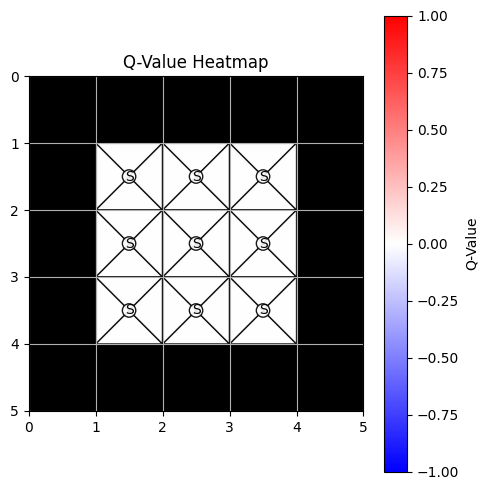

In [ ]:
draw_q_grid(qlearn.q_table, env, scale=1)

In [ ]:
train(agent,env,qlearn, 10, random_init=True)

✅ Visualizing Learned Q-Values After Training
Now that the Q-learning agent has been trained, we visualize the updated Q-values across the grid.

🧭 What You're Seeing:

Each grid cell contains four arrows (or no arrow), one for each possible action: "stay", "up", "down", "left", "right".

The color represents the Q-value associated with that action from that state:

Brighter colors indicate higher Q-values (more favorable choices).

Short or faded arrows indicate less promising actions.

🏁 Interpreting the Output:

The dominant arrow in each cell shows the best action the agent has learned to take from that state.

In empty spaces (walkable tiles), you should see a clear directional path pointing toward the goal.

Near obstacles and boundaries, arrows may avoid certain directions due to the negative rewards.



🔁 Reflection:

Does the agent learn to avoid negative-reward obstacles?

Does it discover the shortest or safest route to the goal?

How does exploration (via ε-greedy behavior) influence its learning?

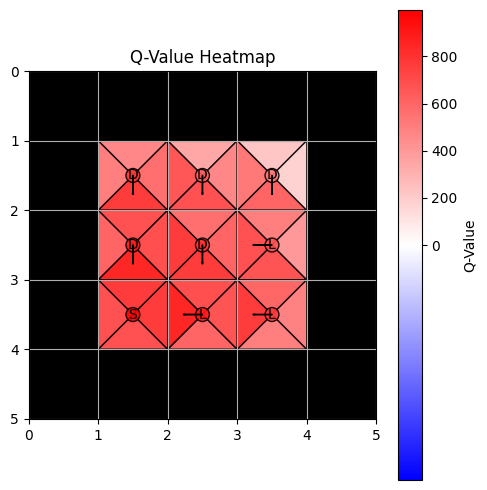

In [ ]:
draw_q_grid(qlearn.q_table, env, scale=1)

🎞️ Visualizing the Agent's Learned Behavior in Real Time

This animation shows the agent's movement through the gridworld after training using the learned policy.

🚶 How it works:

The agent starts at a defined position (in this case, (1, 3)) and follows the optimal policy recovered from the trained Q-table.

At each step, it chooses the action with the highest Q-value, aiming to reach the goal while avoiding obstacles and boundaries.

🌟 What to look for:

The trajectory taken reflects the agent’s learned knowledge—paths that avoid penalties and maximize long-term reward.

The agent should move directly or efficiently toward the goal, detouring around negative-reward tiles as needed.

This visualization is a useful tool to qualitatively evaluate policy quality and debug unwanted behaviors such as loops or collisions.

In [ ]:
# Recover policy
policy = recover_policy(qlearn.q_table,qlearn.actions,rows,cols)

### States ###
(0, 0) (0, 1) (0, 2) (0, 3) (0, 4)
(1, 0) (1, 1) (1, 2) (1, 3) (1, 4)
(2, 0) (2, 1) (2, 2) (2, 3) (2, 4)
(3, 0) (3, 1) (3, 2) (3, 3) (3, 4)
(4, 0) (4, 1) (4, 2) (4, 3) (4, 4)

### Actions ###
['stay', 'up', 'down', 'left', 'right']


In [ ]:
#main - test animation -- all good!
scale = 1
fig, ax = plt.subplots(figsize=(env.cols * scale, env.rows * scale))
camera = Camera(fig)# the camera gets our figure


ax.set_xlim(0, env.cols)
ax.set_ylim(0, env.rows)
ax.set_aspect('equal')
ax.set_xticks(np.arange(0, env.cols+1, 1))
ax.set_yticks(np.arange(0, env.rows+1, 1))
ax.invert_yaxis()
ax.grid(True)



obs = env.obstacle_positions
bounds = env.bound_positions
goal = env.goal_positions[0]

anim = Move_anim(ax, camera, obs, goal, bounds, invert=True)


start = (1,3)
trajectories = Trajectory(policy=policy)
traj = trajectories.step(start,goal)

anim.execute_traj(traj, *start)


animation = camera.animate()
plt.close()
HTML(animation.to_html5_video())

🔍 Scaling Up the State Space
Let’s examine what happens when we scale our environment from a small
5
×
5
5×5 grid to a larger
10
×
10
10×10 gridworld.

🧱 What’s changed:

The number of possible states has increased significantly, from 25 to 100.

We've added more obstacles, creating narrow paths and dead ends that increase the complexity of the environment.

The goal state remains the same—a high-reward tile (+100) the agent must learn to reach.

⚠️ Why this matters:

With a larger state space, the agent now needs to explore and evaluate more transitions.

This introduces the curse of dimensionality: as the number of states grows, the learning process slows down, and more episodes are required to converge on a good policy.

✅ What to look for:

The agent does eventually learn a valid policy, but it takes more time and experience.

This example highlights how scaling up environments increases computational demands and is a key challenge in real-world reinforcement learning problems.

Below, we print the initial grid layout to visualize the new configuration of walkable paths, obstacles, and the goal.

In [ ]:
rows, cols = 10, 10


# Define obstacle and goal positions

obs = {
    (2, 2): -40, (2, 7): -40, (3, 3): -40, (3, 6): -40,
    (4, 4): -40, (5, 2): -40, (5, 8): -40,
    (6, 3): -40, (6, 7): -40
}

goal = {
    (7, 1): 100
}

env = GridWorld(obs=obs, goal=goal, rows=rows, cols=cols, episode_steps=1000)

agent = Agent()

qlearn = QLearning(env=env,epsilon=0.2)


print("Grid Layout")
print(env.grid)


Grid Layout
[[-100 -100 -100 -100 -100 -100 -100 -100 -100 -100]
 [-100    0    0    0    0    0    0    0    0 -100]
 [-100    0  -40    0    0    0    0  -40    0 -100]
 [-100    0    0  -40    0    0  -40    0    0 -100]
 [-100    0    0    0  -40    0    0    0    0 -100]
 [-100    0  -40    0    0    0    0    0  -40 -100]
 [-100    0    0  -40    0    0    0  -40    0 -100]
 [-100  100    0    0    0    0    0    0    0 -100]
 [-100    0    0    0    0    0    0    0    0 -100]
 [-100 -100 -100 -100 -100 -100 -100 -100 -100 -100]]


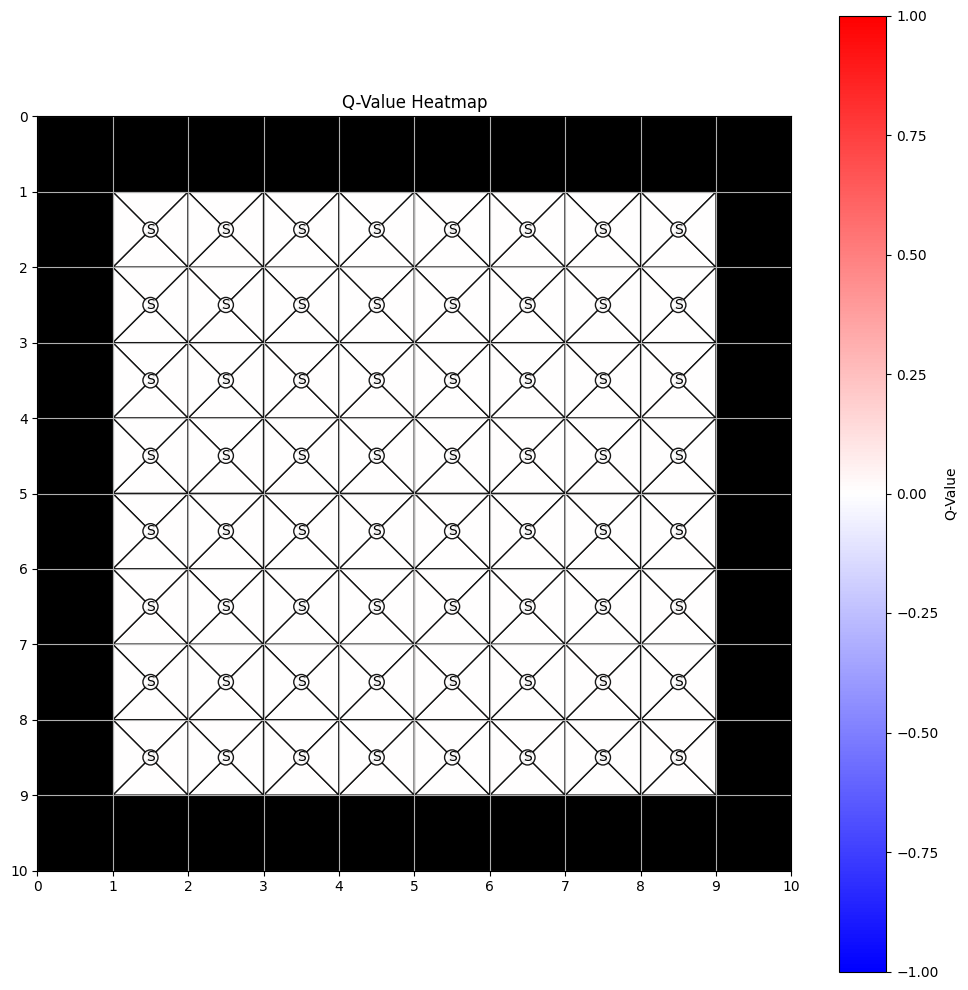

In [ ]:
draw_q_grid(qlearn.q_table, env, scale=1)


In [ ]:
train(agent,env,qlearn, 10000, random_init=True)

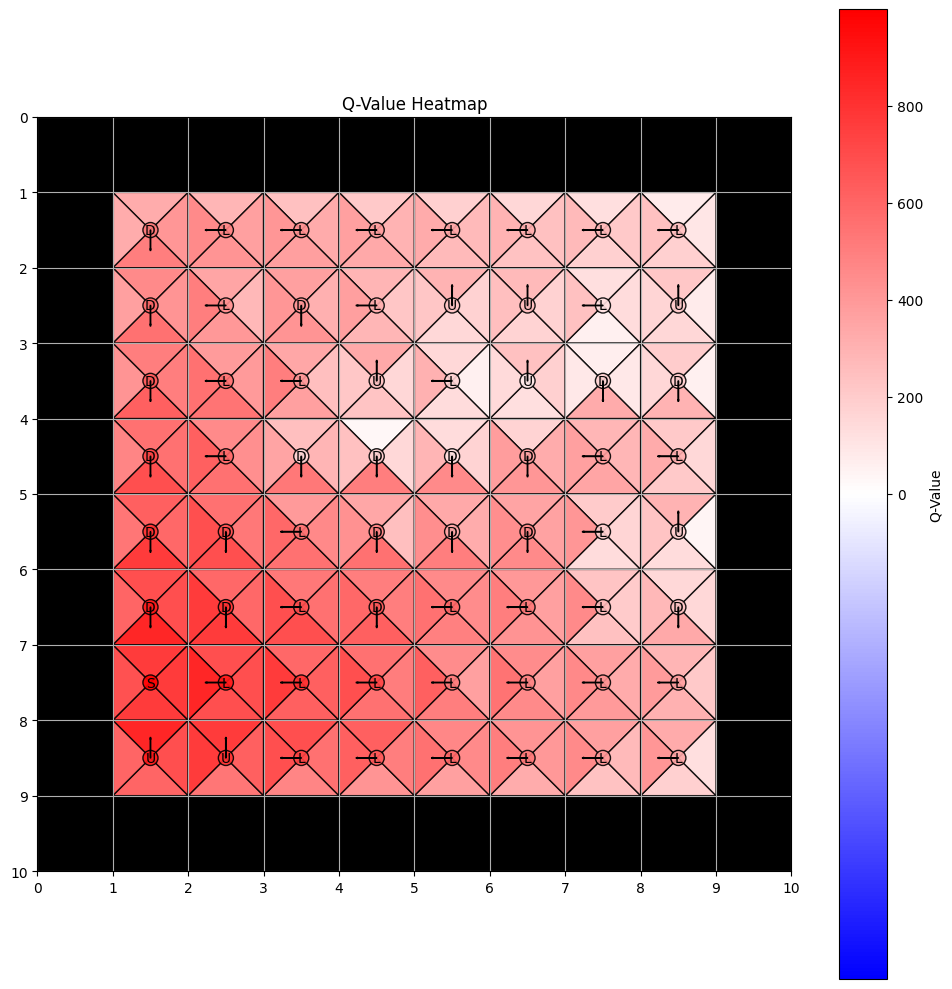

In [ ]:
#draw_q_grid(qlearn.q_table, env, scale=2, focus_center=(2, 2), focus_size=3)
draw_q_grid(qlearn.q_table, env, scale=1)


In [ ]:
# Recover policy
policy = recover_policy(qlearn.q_table,qlearn.actions,rows,cols)

### States ###
(0, 0) (0, 1) (0, 2) (0, 3) (0, 4) (0, 5) (0, 6) (0, 7) (0, 8) (0, 9)
(1, 0) (1, 1) (1, 2) (1, 3) (1, 4) (1, 5) (1, 6) (1, 7) (1, 8) (1, 9)
(2, 0) (2, 1) (2, 2) (2, 3) (2, 4) (2, 5) (2, 6) (2, 7) (2, 8) (2, 9)
(3, 0) (3, 1) (3, 2) (3, 3) (3, 4) (3, 5) (3, 6) (3, 7) (3, 8) (3, 9)
(4, 0) (4, 1) (4, 2) (4, 3) (4, 4) (4, 5) (4, 6) (4, 7) (4, 8) (4, 9)
(5, 0) (5, 1) (5, 2) (5, 3) (5, 4) (5, 5) (5, 6) (5, 7) (5, 8) (5, 9)
(6, 0) (6, 1) (6, 2) (6, 3) (6, 4) (6, 5) (6, 6) (6, 7) (6, 8) (6, 9)
(7, 0) (7, 1) (7, 2) (7, 3) (7, 4) (7, 5) (7, 6) (7, 7) (7, 8) (7, 9)
(8, 0) (8, 1) (8, 2) (8, 3) (8, 4) (8, 5) (8, 6) (8, 7) (8, 8) (8, 9)
(9, 0) (9, 1) (9, 2) (9, 3) (9, 4) (9, 5) (9, 6) (9, 7) (9, 8) (9, 9)

### Actions ###
['stay', 'up', 'down', 'left', 'right']


In [ ]:
policy.get((1,3))

'left'

In [ ]:
for a in ["up", "down", "left", "right", "stay"]:
    print(f"Q((1, 3), {a}) = {qlearn.get_q((1, 3), a)}")


Q((1, 3), up) = 287.3735613726914
Q((1, 3), down) = 438.3483099860814
Q((1, 3), left) = 478.2968999999947
Q((1, 3), right) = 387.4171927364401
Q((1, 3), stay) = 430.46234073628415


In [ ]:
#main - test animation -- all good!
scale = 1
fig, ax = plt.subplots(figsize=(env.cols * scale, env.rows * scale))

camera = Camera(fig)# the camera gets our figure


ax.set_xlim(0, env.cols)
ax.set_ylim(0, env.rows)
ax.set_aspect('equal')
ax.set_xticks(np.arange(0, env.cols+1, 1))
ax.set_yticks(np.arange(0, env.rows+1, 1))
ax.invert_yaxis()
ax.grid(True)



obs = env.obstacle_positions
bounds = env.bound_positions
goal = env.goal_positions[0]
anim = Move_anim(ax, camera, obs, goal, bounds, invert=True)


start = (2,8)
trajectories = Trajectory(policy=policy)
traj = trajectories.step(start,goal)

anim.execute_traj(traj, *start)


animation = camera.animate()
plt.close()
HTML(animation.to_html5_video())